In [39]:
import sympy as sm
from sympy import diff, Symbol
from scipy.integrate import odeint
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math

In [40]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [41]:
m,g = sm.symbols('m g', real =True)
theta, r = dynamicsymbols('theta r')
thetad = dynamicsymbols('theta',1)
thetadd = dynamicsymbols('theta',2)
rd = dynamicsymbols('r',1)
rdd = dynamicsymbols('r',2)
m,g,theta,r,thetad, thetadd, rd, rdd

(m, g, theta, r, theta', theta'', r', r'')

In [42]:
x = r*sm.cos(theta)
y = r*sm.sin(theta)
x,y

(r*cos(theta), r*sin(theta))

In [43]:
xd = sm.diff(x,'t')
yd = sm.diff(y,'t')
xd,yd

(-r*sin(theta)*theta' + cos(theta)*r', r*cos(theta)*theta' + sin(theta)*r')

In [44]:
xdd = sm.diff(xd,'t')
ydd = sm.diff(yd,'t')
xdd, ydd

(-r*sin(theta)*theta'' - r*cos(theta)*theta'**2 - 2*sin(theta)*r'*theta' + cos(theta)*r'', -r*sin(theta)*theta'**2 + r*cos(theta)*theta'' + sin(theta)*r'' + 2*cos(theta)*r'*theta')

In [45]:
dynamics_sol = sm.solve([(m*xdd)  ,((m*ydd)+(m*g)) ],[rdd,thetadd])
rdd_solver = sm.simplify(dynamics_sol[rdd])
thetadd_solver = sm.simplify(dynamics_sol[thetadd])
rdd_solver,thetadd_solver

(-g*sin(theta) + r*theta'**2, -(g*cos(theta) + 2*r'*theta')/r)

In [46]:
M = sm.Matrix([[m, 0],[0, m]])
M

Matrix([
[m, 0],
[0, m]])

In [47]:
a0 = sm.Matrix([rdd_solver, thetadd_solver])
a0

Matrix([
[    -g*sin(theta) + r*theta'**2],
[-(g*cos(theta) + 2*r'*theta')/r]])

In [48]:
F = m*a0
F

Matrix([
[  m*(-g*sin(theta) + r*theta'**2)],
[-m*(g*cos(theta) + 2*r'*theta')/r]])

<h3>constraint is described by</h3>

In [49]:
r_c = sm.exp(0.1*theta)
theta_c = -Symbol('t')+30
r_c,theta_c

(exp(0.1*theta), 30 - t)

In [50]:
r_cdd = sm.diff(sm.diff(r_c,'t'),'t')
theta_cdd = sm.diff(sm.diff(theta_c,'t'),'t')
r_cdd, theta_cdd

(0.01*exp(0.1*theta)*theta'**2 + 0.1*exp(0.1*theta)*theta'', 0)

In [51]:
r_ac = rdd - r_cdd
theta_ac = thetadd - theta_cdd
r_ac,theta_ac

(-0.01*exp(0.1*theta)*theta'**2 - 0.1*exp(0.1*theta)*theta'' + r'', theta'')

In [52]:
rs1 = r_ac.coeff(rdd)
thetas1 = r_ac.coeff(thetadd)
rs2 = theta_ac.coeff(rdd)
thetas2 = theta_ac.coeff(thetadd)
A = sm.Matrix([[rs1,thetas1],[rs2,thetas2]])
A

Matrix([
[1, -0.1*exp(0.1*theta)],
[0,                   1]])

In [53]:
b1 = -(r_ac - rs1*rdd - thetas1*thetadd)
b2 = -(theta_ac - rs2*rdd - thetas2*thetadd)
b = sm.Matrix([b1 , b2])
b

Matrix([
[0.01*exp(0.1*theta)*theta'**2],
[                            0]])

In [54]:
Fc =  M**(1/2)*sm.Matrix.pinv(A*(M**(-1/2)))*(b-(A*(M**(-1))*F))
Fc

Matrix([
[0.1*m**1.0*(g*cos(theta) + 2*r'*theta')*exp(0.1*theta)/r + 1.0*m**1.0*(g*sin(theta) - 0.1*(g*cos(theta) + 2*r'*theta')*exp(0.1*theta)/r - r*theta'**2 + 0.01*exp(0.1*theta)*theta'**2)],
[                                                                                                                                                 m**1.0*(g*cos(theta) + 2*r'*theta')/r]])

In [55]:
rf = F + Fc
rf

Matrix([
[0.1*m**1.0*(g*cos(theta) + 2*r'*theta')*exp(0.1*theta)/r + 1.0*m**1.0*(g*sin(theta) - 0.1*(g*cos(theta) + 2*r'*theta')*exp(0.1*theta)/r - r*theta'**2 + 0.01*exp(0.1*theta)*theta'**2) + m*(-g*sin(theta) + r*theta'**2)],
[                                                                                                                                               -m*(g*cos(theta) + 2*r'*theta')/r + m**1.0*(g*cos(theta) + 2*r'*theta')/r]])

In [56]:
rdd_func = sm.lambdify([m, g, theta, thetad, r, rd], rf[0])
thetadd_func = sm.lambdify([m, g, theta, thetad, r, rd], rf[1])
rd_func = sm.lambdify(rd, rd)
thetad_func = sm.lambdify(thetad, thetad)

In [57]:
# ode func for scipy odeint
def dSdt(S,t,m, g):
    thetv, thetvd ,rv, rvd = S
    return [
        thetad_func(thetvd),
        thetadd_func(m, g, thetv, thetvd, rv, rvd),
        rd_func(rvd),
        rdd_func(m, g, thetv, thetvd, rv, rvd)
    ]

In [89]:
t = np.linspace(0, 50, 251)
m = 1
g = 9.81
r_ic = math.exp(3)
theta_ic = 30
r_d_ic = -0.1*math.exp(3)
theta_d_ic = -1
ans = odeint(dSdt, y0=[theta_ic,theta_d_ic,r_ic,r_d_ic], t=t, args=(m,g))

In [90]:
ans.T

array([[ 3.00000000e+01,  2.98000000e+01,  2.96000000e+01, ...,
        -1.96000000e+01, -1.98000000e+01, -2.00000000e+01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 2.00855369e+01,  1.96878167e+01,  1.92979720e+01, ...,
         1.40856879e-01,  1.38067686e-01,  1.35333722e-01],
       [-2.00855369e+00, -1.96878167e+00, -1.92979720e+00, ...,
        -1.40858902e-02, -1.38069718e-02, -1.35335764e-02]])

In [91]:
thetv_ = ans.T[0]
thetvd_ = ans.T[1]
rv_ = ans.T[2]
rvd_ = ans.T[3]

In [92]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Relation between r and θ in constrained system')

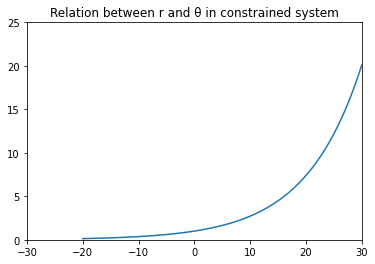

In [97]:
plt.axis([-30, 30, 0, 25])
plt.plot(thetv_, rv_)
plt.title("Relation between r and θ in constrained system")

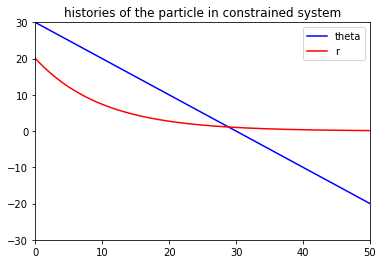

In [96]:
plt.axis([0, 50, -30, 30])
plt.plot(t, thetv_,color='b', label='theta')
plt.plot(t, rv_, color='r', label='r')
plt.title("histories of the particle in constrained system")
plt.legend()
plt.show()

In [98]:
x = r*sm.cos(theta)
y = r*sm.sin(theta)
def get_xy(the, d):
    return (d*np.cos(the),
            d*np.sin(the))


x,y = get_xy(ans.T[0],ans.T[2])

Text(0.5, 1.0, 'Relation between r and θ in constrained system')

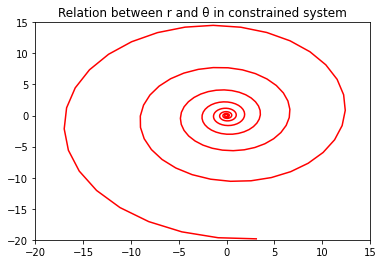

In [100]:
plt.axis([-20, 15, -20, 15])
plt.plot(x, y,color='r')
plt.title("Relation between r and θ in constrained system")